# Transformer Model All

All experiments are run with 15sec-500hz-1norm-10wpp model

Prediction probabilities are emitted for each embedding derived from the sliding window

In [9]:
import os
import sys
import numpy as np
import pandas as pd
import csv
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from pathlib import Path

from tqdm import tqdm
from edm.models.mlp_model import MLP
from edm.utils.measures import perf_measure, calculate_output_statistics, calculate_confidence_intervals

pd.set_option('display.max_columns', None)

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Output Predictions

In [11]:

class MLPDataLoader(Dataset):
    def __init__(self, waveform_df):
        self.waveform_df = waveform_df

    def __len__(self):
        return len(self.waveform_df)
    
    def get_labels(self):
        return self.waveform_df["outcome"].to_numpy().astype(np.int64)

    def __getitem__(self, idx):
        patient_id = self.waveform_df.iloc[[idx]]["patient_id"].item()
        cls = self.waveform_df.iloc[[idx]]["outcome"].item()
        quality = self.waveform_df.iloc[[idx]]["quality"].item()
        lead_time = self.waveform_df.iloc[[idx]]["lead_time"].item()

        cols_to_drop = ["patient_id", "outcome", "quality", "lead_time"]
        dims = self.waveform_df.iloc[[idx]].drop(cols_to_drop, axis=1)
        dims = dims.to_numpy()
        return np.squeeze(dims, axis=0), int(cls), patient_id, quality, lead_time

    

In [12]:

def test_mlp(df, 
             model_path, 
             batch_size=128, 
             learning_rate=0.00001, 
             dropout_rate=0, 
             num_inner_layers=2, 
             epochs=100, 
             inner_dim=128,
             dropout=True, 
             embed_dim=64,
             save_predictions_path=None, 
             verbose=0):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    model = MLP(embed_dim, dropout=dropout, inner_dim=inner_dim,
                         dropout_rate=dropout_rate, num_inner_layers=num_inner_layers).to(device)

    if torch.cuda.is_available():
        checkpoint = torch.load(model_path)
    else:
        checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

    state_dict = checkpoint['state_dict']
    for k in list(state_dict.keys()):
        # Remove the model prefix that Pytorch-Lightning applies
        state_dict[k.replace("model.", "")] = state_dict.pop(k)
    model.load_state_dict(state_dict)
    model.eval()
    
    test_dats = MLPDataLoader(df)
    test_loader = DataLoader(test_dats, batch_size=batch_size, shuffle=False, num_workers=4)
    
    final_patient_ids = []
    final_quality = []
    final_lead_time = []
    final_preds = []
    final_y = []
    
    for batch in tqdm(test_loader):
        x, y, patient_id, quality, lead_time = batch
        x = x.to(device=device, dtype=torch.float)
        output = model(x)
        preds = torch.sigmoid(output)
        preds = torch.squeeze(preds)
        preds = preds.cpu()
        y = y.cpu().int()
        patient_id = patient_id.cpu()
        patient_id_list = [patient_id[i].item() for i in range(len(patient_id))]
        quality = quality.cpu()
        quality_list = [quality[i].item() for i in range(len(quality))]
        lead_time = lead_time.cpu()
        lead_time_list = [lead_time[i].item() for i in range(len(lead_time))]

        final_patient_ids.extend(patient_id_list)
        final_quality.extend(quality_list)
        final_lead_time.extend(lead_time_list)
        final_preds.extend(preds.clone().detach().cpu().numpy().tolist())
        final_y.extend(y.clone().detach().cpu().numpy().tolist())

    if verbose >= 1:
        print()
        print()
        print("============= TEST ROC CURVE ===============")

    auroc_test = calculate_output_statistics(final_y, final_preds, show_plots=False)
    precision, recall, _ = precision_recall_curve(final_y, final_preds)
    auprc_alt = auc(recall, precision)
    if verbose >= 1:
        print(f"TEST AUROC = {auroc_test} AUPRC = {auprc_alt} using data size {len(final_preds)} with {sum(final_y)} pos")
        calculate_confidence_intervals(final_y, final_preds, ci_type="delong")
        # Note that bootstrap would require > 24 hours to complete and is skipped here
        # calculate_confidence_intervals(final_y, final_preds, ci_type="bootstrap")

    if save_predictions_path is not None:
        with open(f"{save_predictions_path}", "w") as fp:
            writer = csv.writer(fp, delimiter=",")
            writer.writerow(["patient_id", "quality", "lead_time", "preds", "actual"])
            for ind in range(len(final_patient_ids)):
                writer.writerow([final_patient_ids[ind], final_quality[ind], final_lead_time[ind], final_preds[ind], final_y[ind]])

    return final_patient_ids, final_preds, final_y, final_quality, final_lead_time


In [13]:

def get_embedding_df(df, summary_df, waveforms, outcome_col="outcome"):
    pt_to_outcome = {}
    for i, row in df.iterrows():
        pt_to_outcome[row["CSN"]] = row[outcome_col]
    
    print(f"Read {len(pt_to_outcome)} pt_to_outcome")
    
    embed_size = waveforms.shape[1]
    
    output = []
    
    for i, row in tqdm(summary_df.iterrows(), total=len(summary_df)):
        patient_id = int(row["patient_id"])
        quality = int(row["quality"])
        lead_time = int(row["lead_time"])
        outcome = pt_to_outcome[patient_id]
        new_row = [patient_id, outcome, quality, lead_time]

        new_row.extend(waveforms[i])    
        output.append(new_row)
    
    headers = ["patient_id", "outcome", "quality", "lead_time"]

    for i in range(embed_size):
        headers.append(f"embed_{i}")
    
    return pd.DataFrame(output, columns=headers)

In [7]:
df = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.csv", na_values='?')
df.shape

(10874, 79)

In [ ]:
summary_df = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/waveforms/15sec-500hz-1norm-all/transformer-64/II/summary.csv")
waveforms = np.load("/deep/group/ed-monitor/patient_data_v9/waveforms/15sec-500hz-1norm-all/transformer-64/II/embeddings.dat.npy")
summary_df.head(3)

In [8]:
summary_df_x = get_embedding_df(df, summary_df, waveforms)
print(f"Produced embedding for summary_df_x with shape = {summary_df_x.shape}")


  0%|          | 587/389009 [00:00<01:06, 5862.22it/s]

Read 10874 pt_to_outcome


100%|██████████| 389009/389009 [01:21<00:00, 4796.70it/s]


Produced embedding for summary_df_x with shape = (389009, 68)


In [9]:
summary_df_x.to_csv("/deep/group/ed-monitor/patient_data_v9/waveforms/15sec-500hz-1norm-all/transformer-64/II/embedding.csv", index=False)


In [14]:
summary_df_x = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/waveforms/15sec-500hz-1norm-all/transformer-64/II/embedding.csv")

In [ ]:
summary_df_x.head(2)

In [15]:
Path("/deep/group/ed-monitor/patient_data_v9/predictions/15sec-500hz-1norm-all/final-transformer-64/II/").mkdir(parents=True, exist_ok=True)

final_patient_ids, final_preds, final_y, final_quality, final_lead_time = test_mlp(summary_df_x, 
     "/deep/group/ed-monitor/patient_data_v9/predictions/15sec-500hz-1norm-10wpp/II/final-transformer-64/waveform-only/epoch=45-step=2943.ckpt", 
     dropout=True, 
     dropout_rate=0.3, 
     num_inner_layers=3, 
     batch_size=128, 
     inner_dim=128,
     embed_dim=summary_df_x.shape[1] - 4,
     save_predictions_path="/deep/group/ed-monitor/patient_data_v9/predictions/15sec-500hz-1norm-all/final-transformer-64/II/predictions.csv",
     verbose=1
)

100%|██████████| 3040/3040 [06:14<00:00,  8.12it/s]




============= TEST ROC CURVE ===============
TEST AUROC = (0.6803543369317856, 0.21648322190987634) AUPRC = 0.21648322190987634 using data size 389009 with 40515 pos
[DeLong] AUC=0.68, AUC COV=0.0, 95% CI=[0.678, 0.683]; AUPRC=0.216, 95% CI=N/A


### ECG Model Duration Comparisons

In [ ]:
df = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/15sec-500hz-1norm-all/final-transformer-64/II/predictions.csv")
df = df[df["quality"] == 1]
df.head(3)

In [17]:
def print_stats(df):
    final_y = df["actual"].tolist()
    final_preds = df["preds"].tolist()
    auroc_test = calculate_output_statistics(final_y, final_preds, show_plots=False)
    print(f"AUC = {auroc_test}")
    calculate_confidence_intervals(final_y, final_preds, ci_type="delong")
#     calculate_confidence_intervals(final_y, final_preds, ci_type="bootstrap")

#### Single Segment

In [18]:
# Lead Time = 0 hour
print_stats(df[df["lead_time"] == 0])

AUC = (0.7067965023847378, 0.21593511892214484)
[DeLong] AUC=0.707, AUC COV=0.0, 95% CI=[0.664, 0.75]; AUPRC=0.216, 95% CI=N/A


In [19]:
# Lead Time = 1 hour
print_stats(df[df["lead_time"] == 60 * 60 * 1])

AUC = (0.6722479863314621, 0.2607925875829061)
[DeLong] AUC=0.672, AUC COV=0.001, 95% CI=[0.613, 0.731]; AUPRC=0.261, 95% CI=N/A


In [20]:
# Lead Time = 2 hour
print_stats(df[df["lead_time"] == 60 * 60 * 2])

AUC = (0.6385836385836386, 0.1191576745006248)
[DeLong] AUC=0.639, AUC COV=0.007, 95% CI=[0.469, 0.808]; AUPRC=0.119, 95% CI=N/A


In [21]:
# Lead Time = 3 hour
print_stats(df[df["lead_time"] == 60 * 60 * 3])

AUC = (0.5866666666666667, 0.2779427736006683)
[DeLong] AUC=0.587, AUC COV=0.026, 95% CI=[0.269, 0.904]; AUPRC=0.278, 95% CI=N/A


In [22]:
# Lead Time = 4 hour
print_stats(df[df["lead_time"] == 60 * 60 * 4])

AUC = (0.5833333333333333, 0.4065972222222223)
[DeLong] AUC=0.583, AUC COV=0.044, 95% CI=[0.17, 0.997]; AUPRC=0.407, 95% CI=N/A


#### Mean of All

In [23]:
# Lead Time = 1 hour
print_stats(df[df["lead_time"] < 60 * 60 * 1].groupby(['patient_id'], as_index=False).mean())

AUC = (0.7225815367606412, 0.2760992389915496)
[DeLong] AUC=0.723, AUC COV=0.0, 95% CI=[0.68, 0.765]; AUPRC=0.276, 95% CI=N/A


In [24]:
# Lead Time = 2 hour
print_stats(df[df["lead_time"] < 60 * 60 * 2].groupby(['patient_id'], as_index=False).mean())

AUC = (0.7243781094527363, 0.2769524047994995)
[DeLong] AUC=0.724, AUC COV=0.0, 95% CI=[0.683, 0.766]; AUPRC=0.277, 95% CI=N/A


In [25]:
# Lead Time = 3 hour
print_stats(df[df["lead_time"] < 60 * 60 * 3].groupby(['patient_id'], as_index=False).mean())

AUC = (0.7242233278054173, 0.27668332729815026)
[DeLong] AUC=0.724, AUC COV=0.0, 95% CI=[0.682, 0.766]; AUPRC=0.277, 95% CI=N/A


In [26]:
# Lead Time = 4 hour
print_stats(df[df["lead_time"] < 60 * 60 * 4].groupby(['patient_id'], as_index=False).mean())

AUC = (0.7245605306799336, 0.27697313189515854)
[DeLong] AUC=0.725, AUC COV=0.0, 95% CI=[0.683, 0.766]; AUPRC=0.277, 95% CI=N/A


#### Mean of 10 Random

In [27]:
size = 10        # sample size
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, min(obj.shape[0], size), replace), :]

In [28]:
# Lead Time = 1 hour
print_stats(df[df["lead_time"] < 60 * 60 * 1].groupby(['patient_id'], as_index=False).apply(fn))

AUC = (0.7138762354086718, 0.2513187155738704)
[DeLong] AUC=0.714, AUC COV=0.0, 95% CI=[0.701, 0.727]; AUPRC=0.251, 95% CI=N/A


In [29]:
# Lead Time = 2 hour
print_stats(df[df["lead_time"] < 60 * 60 * 2].groupby(['patient_id'], as_index=False).apply(fn))

AUC = (0.7066077298161271, 0.25171937629741)
[DeLong] AUC=0.707, AUC COV=0.0, 95% CI=[0.693, 0.72]; AUPRC=0.252, 95% CI=N/A


In [30]:
# Lead Time = 3 hour
print_stats(df[df["lead_time"] < 60 * 60 * 3].groupby(['patient_id'], as_index=False).apply(fn))

AUC = (0.7085999507555336, 0.2466263042714976)
[DeLong] AUC=0.709, AUC COV=0.0, 95% CI=[0.695, 0.722]; AUPRC=0.247, 95% CI=N/A


In [31]:
# Lead Time = 4 hour
print_stats(df[df["lead_time"] < 60 * 60 * 4].groupby(['patient_id'], as_index=False).apply(fn))

AUC = (0.7055625565424011, 0.24928826946817817)
[DeLong] AUC=0.706, AUC COV=0.0, 95% CI=[0.692, 0.719]; AUPRC=0.249, 95% CI=N/A


#### Most Confident

In [33]:
optimal_threshold=0.08275610953569412 # From Prediction Notebook

pt_to_best_highest = {}
pt_to_best_lowest = {}

for i, row in tqdm(df.iterrows()):
    pt = row["patient_id"]
    lt = row["lead_time"]
    preds = row["preds"]
    if pt not in pt_to_best_highest:
        pt_to_best_highest[pt] = [0, lt]
        pt_to_best_lowest[pt] = [1, lt]
    if pt_to_best_highest[pt][0] < preds:
        pt_to_best_highest[pt] = [preds, lt]
    if pt_to_best_lowest[pt][0] > preds:
        pt_to_best_lowest[pt] = [preds, lt]

pt_to_lt = {}
for k in pt_to_best_highest.keys():
    if pt_to_best_highest[k][0] < optimal_threshold:
        pt_to_lt[k] = pt_to_best_lowest[k][1]
    elif pt_to_best_lowest[k][0] > optimal_threshold:
        pt_to_lt[k] = pt_to_best_highest[k][1]
    else:
        dist_to_high = pt_to_best_highest[k][0] - optimal_threshold
        dist_to_low = optimal_threshold - pt_to_best_lowest[k][0]
        if dist_to_high > dist_to_low:
            pt_to_lt[k] = pt_to_best_highest[k][1]
        else:
            pt_to_lt[k] = pt_to_best_lowest[k][1]


362777it [00:45, 7910.88it/s]


In [34]:
# Lead Time = 1 hour
df_l = df[df["lead_time"] < 60 * 60 * 1]
df_l = df_l[df_l.apply(lambda x: x['patient_id'] in pt_to_lt and x['lead_time'] == pt_to_lt[x['patient_id']], axis=1)]
print(df_l.shape)
print_stats(df_l)

(1145, 5)
AUC = (0.6806437242454616, 0.2250177539890506)
[DeLong] AUC=0.681, AUC COV=0.001, 95% CI=[0.631, 0.73]; AUPRC=0.225, 95% CI=N/A


In [35]:
# Lead Time = 2 hour
df_l = df[df["lead_time"] < 60 * 60 * 2]
df_l = df_l[df_l.apply(lambda x: x['patient_id'] in pt_to_lt and x['lead_time'] == pt_to_lt[x['patient_id']], axis=1)]
print(df_l.shape)
print_stats(df_l)

(1336, 5)
AUC = (0.6732991826867734, 0.2254394900075444)
[DeLong] AUC=0.673, AUC COV=0.001, 95% CI=[0.628, 0.719]; AUPRC=0.225, 95% CI=N/A


In [36]:
# Lead Time = 3 hour
df_l = df[df["lead_time"] < 60 * 60 * 3]
df_l = df_l[df_l.apply(lambda x: x['patient_id'] in pt_to_lt and x['lead_time'] == pt_to_lt[x['patient_id']], axis=1)]
print(df_l.shape)
print_stats(df_l)

(1353, 5)
AUC = (0.6725958215344824, 0.22737159329356543)
[DeLong] AUC=0.673, AUC COV=0.001, 95% CI=[0.627, 0.718]; AUPRC=0.227, 95% CI=N/A


In [37]:
# Lead Time = 4 hour
df_l = df[df["lead_time"] < 60 * 60 * 4]
df_l = df_l[df_l.apply(lambda x: x['patient_id'] in pt_to_lt and x['lead_time'] == pt_to_lt[x['patient_id']], axis=1)]
print(df_l.shape)
print_stats(df_l)

(1356, 5)
AUC = (0.6712658927584301, 0.2240943755359856)
[DeLong] AUC=0.671, AUC COV=0.001, 95% CI=[0.626, 0.716]; AUPRC=0.224, 95% CI=N/A


### Logits Over Time

In [ ]:
df = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/15sec-500hz-1norm-all/final-transformer-64/II/predictions.csv")
df.head(3)

In [39]:
df = df.sort_values(["patient_id", "lead_time"])


In [40]:
acs_start_to_outputs = {}
nonacs_start_to_outputs = {}
quality_start_to_outputs = {}

def add_to_start_to_outputs(k, v, is_acs):
    if is_acs:
        if k not in acs_start_to_outputs:
            acs_start_to_outputs[k] = []
        acs_start_to_outputs[k].append(v)
    else:
        if k not in nonacs_start_to_outputs:
            nonacs_start_to_outputs[k] = []
        nonacs_start_to_outputs[k].append(v)

start = None
patient_id_to_start = {}
for i, row in tqdm(df.iterrows()):
    patient_id = int(row["patient_id"])

    outcome = int(row["actual"])
    pred = float(row["preds"])
    lead_time = float(row["lead_time"])
    quality = float(row["quality"])
    if quality == 1:
        if patient_id not in patient_id_to_start:
            patient_id_to_start[patient_id] = lead_time

        if outcome == 1:
            add_to_start_to_outputs(lead_time, pred, True)
        else:
            add_to_start_to_outputs(lead_time, pred, False)


389009it [00:56, 6843.44it/s]


In [41]:
acs_mean_logits = []
acs_std_logits = []
acs_x = []
nonacs_mean_logits = []
nonacs_std_logits = []
nonacs_x = []

for k in sorted(list(acs_start_to_outputs.keys())):
    acs_mean_logits.append(np.mean(acs_start_to_outputs[k]))
    acs_std_logits.append(np.std(acs_start_to_outputs[k]))
    acs_x.append(k / 60)
    if k > 4 * 60 * 60:
        break
    
for k in sorted(list(nonacs_start_to_outputs.keys())):
    nonacs_mean_logits.append(np.mean(nonacs_start_to_outputs[k]))
    nonacs_std_logits.append(np.std(nonacs_start_to_outputs[k]))
    nonacs_x.append(k / 60)
    if k > 4 * 60 * 60:
        break


In [42]:
len(np.array(nonacs_x) - np.array(nonacs_mean_logits))

961

<Figure size 640x480 with 0 Axes>

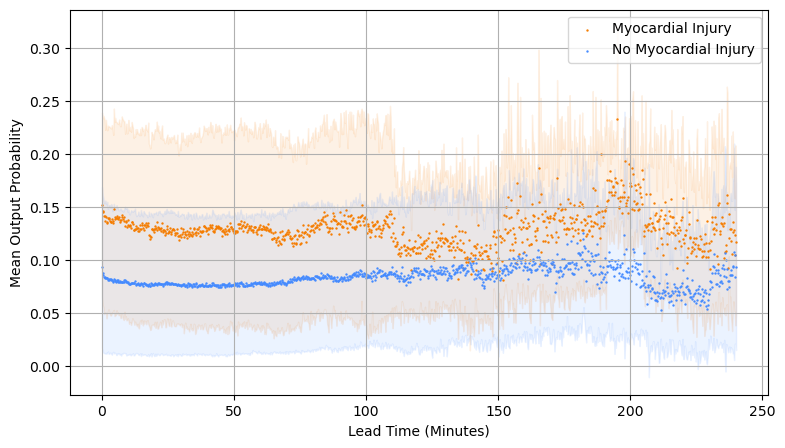

In [43]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.close()
plt.figure(0).clf()
a4_dims = (9, 5)
fig, ax = plt.subplots(figsize=a4_dims)

ax.set_xlabel('Lead Time (Minutes)')
ax.set_ylabel('Mean Output Probability')

ax.fill_between(acs_x, np.array(acs_mean_logits) - np.array(acs_std_logits), 
                np.array(acs_mean_logits) + np.array(acs_std_logits), color="#F57C00", alpha=0.1)
ax.fill_between(nonacs_x, np.array(nonacs_mean_logits) - np.array(nonacs_std_logits), 
                np.array(nonacs_mean_logits) + np.array(nonacs_std_logits), color="#448AFF", alpha=0.1)
ax.scatter(acs_x, acs_mean_logits, label='Myocardial Injury', color="#F57C00", s=0.5)
ax.scatter(nonacs_x, nonacs_mean_logits, label='No Myocardial Injury', color="#448AFF", s=0.5)

ax.grid()
ax.legend(loc=0)
plt.show()

In [44]:
len(acs_x)

961

In [45]:
len(nonacs_x)

961

### Logits (Single Pt)

In [ ]:
df = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/15sec-500hz-1norm-all/final-transformer-64/II/predictions.csv")
df.head(3)

In [ ]:
df[df["actual"] == 1]

In [49]:
acs_start_to_outputs = {}
nonacs_start_to_outputs = {}
quality_start_to_outputs = {}

def add_to_start_to_outputs(k, v, is_acs):
    if is_acs:
        if k not in acs_start_to_outputs:
            acs_start_to_outputs[k] = []
        acs_start_to_outputs[k].append(v)
    else:
        if k not in nonacs_start_to_outputs:
            nonacs_start_to_outputs[k] = []
        nonacs_start_to_outputs[k].append(v)

start = None
patient_id_to_start = {}
for i, row in tqdm(df.iterrows()):
    patient_id = int(row["patient_id"])

    outcome = int(row["actual"])
    pred = float(row["preds"])
    lead_time = float(row["lead_time"])
    quality = float(row["quality"])
    if quality == 1:
        if patient_id not in patient_id_to_start:
            patient_id_to_start[patient_id] = lead_time

        if outcome == 1:
            add_to_start_to_outputs(lead_time, pred, True)
        else:
            add_to_start_to_outputs(lead_time, pred, False)


196it [00:00, 6717.52it/s]


In [50]:
acs_mean_logits = []
acs_std_logits = []
acs_x = []
nonacs_mean_logits = []
nonacs_std_logits = []
nonacs_x = []

for k in sorted(list(acs_start_to_outputs.keys())):
    acs_mean_logits.append(np.mean(acs_start_to_outputs[k]))
    acs_std_logits.append(np.std(acs_start_to_outputs[k]))
    acs_x.append(k / 60)
    if k > 4 * 60 * 60:
        break
    
for k in sorted(list(nonacs_start_to_outputs.keys())):
    nonacs_mean_logits.append(np.mean(nonacs_start_to_outputs[k]))
    nonacs_std_logits.append(np.std(nonacs_start_to_outputs[k]))
    nonacs_x.append(k / 60)
    if k > 4 * 60 * 60:
        break


<Figure size 640x480 with 0 Axes>

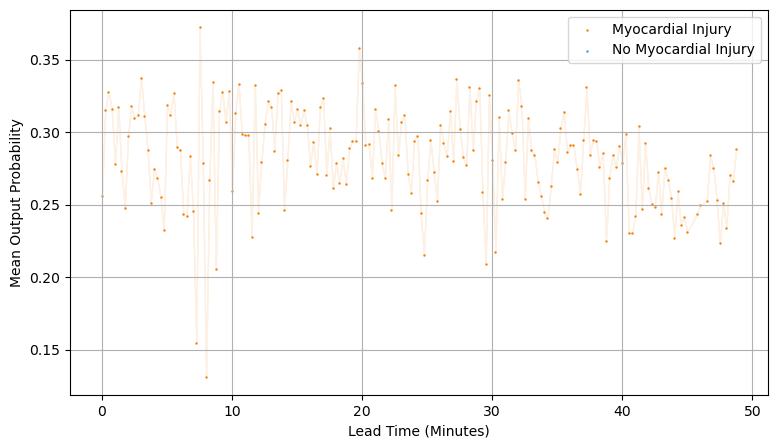

In [51]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.close()
plt.figure(0).clf()
a4_dims = (9, 5)
fig, ax = plt.subplots(figsize=a4_dims)

ax.set_xlabel('Lead Time (Minutes)')
ax.set_ylabel('Mean Output Probability')

ax.fill_between(acs_x, np.array(acs_mean_logits) - np.array(acs_std_logits), 
                np.array(acs_mean_logits) + np.array(acs_std_logits), color="#F57C00", alpha=0.1)
ax.fill_between(nonacs_x, np.array(nonacs_mean_logits) - np.array(nonacs_std_logits), 
                np.array(nonacs_mean_logits) + np.array(nonacs_std_logits), color="#448AFF", alpha=0.1)
ax.scatter(acs_x, acs_mean_logits, label='Myocardial Injury', color="#F57C00", s=0.5)
ax.scatter(nonacs_x, nonacs_mean_logits, label='No Myocardial Injury', color="#448AFF", s=0.5)

ax.grid()
ax.legend(loc=0)
plt.show()